In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()


2025-09-22 18:10:46.244981: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 18:10:46.262641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758544846.276236   57422 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758544846.280413   57422 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-22 18:10:46.294066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 48, 48, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 48, 48, 3) │          7 │ rescaling[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 48, 48, 3) │          0 │ normalization[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 49, 49, 3) │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 24, 24,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 24, 24,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 24, 24,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 24, 24,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 24, 24,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 24, 24,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 24, 24,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 24, 24,    │        512 │ block1a_se_excit

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.2217 - loss: 1.8546 - val_accuracy: 0.2471 - val_loss: 1.8168 - learning_rate: 1.0000e-04
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2440 - loss: 1.8226 - val_accuracy: 0.2471 - val_loss: 1.8154 - learning_rate: 1.0000e-04
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.2447 - loss: 1.8252 - val_accuracy: 0.2471 - val_loss: 1.8136 - learning_rate: 1.0000e-04
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2502 - loss: 1.8201 - val_accuracy: 0.2471 - val_loss: 1.8152 - learning_rate: 1.0000e-04
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2517 - loss: 1.8203 - val_accuracy: 0.2471 - val_loss: 1.8147 - learning_rate: 1.0000e-04
Epoch 6/20
892/898 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2499 - loss: 1.8158
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
898/898 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2

E0000 00:00:1758545106.031505   57517 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758545106.144180   57517 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758545111.591316   57517 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758545111.703415   57517 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


499/898 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1850 - loss: 2.3669

E0000 00:00:1758545139.828514   57519 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758545139.936959   57519 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758545144.865910   57519 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758545144.976421   57519 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


898/898 ━━━━━━━━━━━━━━━━━━━━ 87s 51ms/step - accuracy: 0.1889 - loss: 2.3246 - val_accuracy: 0.2240 - val_loss: 1.9086 - learning_rate: 1.0000e-05
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.2271 - loss: 2.0629 - val_accuracy: 0.2506 - val_loss: 1.8374 - learning_rate: 1.0000e-05
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.2550 - loss: 1.9455 - val_accuracy: 0.2501 - val_loss: 1.8312 - learning_rate: 1.0000e-05
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.2804 - loss: 1.8612 - val_accuracy: 0.3246 - val_loss: 1.7110 - learning_rate: 1.0000e-05
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.3056 - loss: 1.7805 - val_accuracy: 0.3100 - val_loss: 1.7184 - learning_rate: 1.0000e-05
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.3204 - loss: 1.7348 - val_accuracy: 0.3225 - val_loss: 1.6906 - learning_rate: 1.0000e-05
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accurac

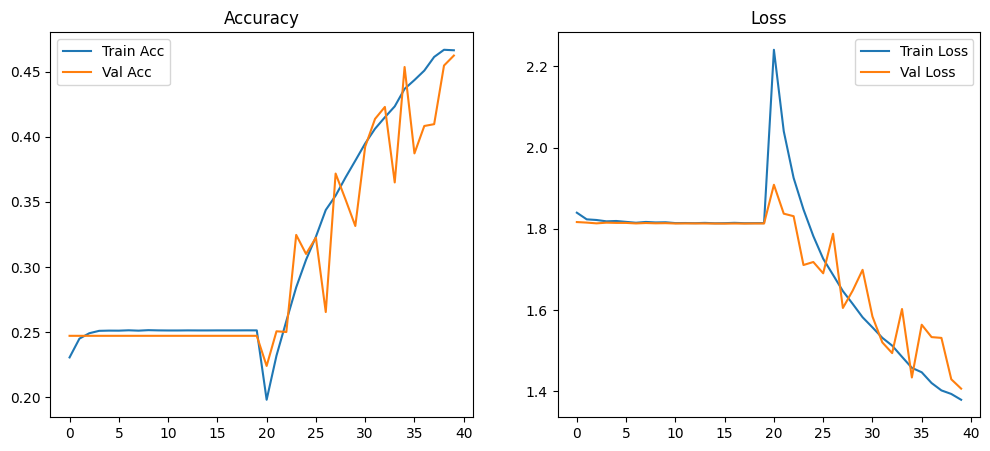

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# ✅ Always clear session in Jupyter to avoid conflicts
tf.keras.backend.clear_session()

# -------------------
# Dataset Paths
# -------------------
train_dir = "../Data/FER/train"
val_dir   = "../Data/FER/test"

# -------------------
# Data Generators (RGB instead of grayscale)
# -------------------
base_datagen = ImageDataGenerator(rescale=1./255)

train_data = base_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="rgb",   # ✅ use RGB
    class_mode="categorical",
    batch_size=32,      # fits into RTX 3050 (4GB)
    shuffle=True
)

val_data = base_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    color_mode="rgb",   # ✅ use RGB
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

# -------------------
# EfficientNetB0 Base (ImageNet Pretrained)
# -------------------
base_model = EfficientNetB0(
    weights="imagenet",        # ✅ pretrained ImageNet
    include_top=False,
    input_tensor=Input(shape=(48, 48, 3))   # ✅ 3 channels
)

# Freeze base model initially
base_model.trainable = False

# -------------------
# Custom Classification Head
# -------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# -------------------
# Compile
# -------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -------------------
# Callbacks
# -------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

# -------------------
# Phase 1: Train only classification head
# -------------------
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

# -------------------
# Phase 2: Fine-tune EfficientNet
# -------------------
base_model.trainable = True   # unfreeze base
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

# -------------------
# Save Model
# -------------------
model.save("fer_efficientnetb0_rgb.h5")

# -------------------
# Plot Accuracy & Loss
# -------------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"] + history_ft.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"] + history_ft.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"] + history_ft.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"] + history_ft.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")

plt.show()


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input

model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224,224,3))   # 👈 default ImageNet input
)

print("EfficientNetB0 built successfully ✅")


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [ ]:
    import tensorflow as tf
    from tensorflow.keras.applications import EfficientNetB0 # Or your desired EfficientNet variant

    # Create the model with 3 input channels (e.g., for RGB images)
    model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [ ]:
import keras
import tensorflow as tf
print("keras version:", keras.__version__)
print("tf version:", tf.__version__)
print("keras location:", keras.__file__)
print("tf.keras location:", tf.keras.__file__)

keras version: 3.11.3
tf version: 2.20.0
keras location: /home/namithk/miniconda3/envs/studysense/lib/python3.10/site-packages/keras/__init__.py
tf.keras location: /home/namithk/miniconda3/envs/studysense/lib/python3.10/site-packages/keras/_tf_keras/keras/__init__.py
